In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

plt.ion()   # interactive mode

In [ ]:
os.chdir('/content/drive/MyDrive/calcification_detection/calcification_detecion/calc-det/notebooks')

In [ ]:
batch_size = 15

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [ ]:
from cv2 import cv2

In [ ]:
image = cv2.imread('/content/drive/MyDrive/calcification_detection/p224_database/train/negative/30011674_roi_275.png', cv2.IMREAD_ANYDEPTH)
#image = rescale_to_int(image)
# image = min_max_norm(image,1)
image = cv2.merge((image,image,image))
print(image.shape)

(224, 224, 3)


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
class Min_max_norm(object):
    def __call__(self, img):
        img = np.array(img)
        img = (img - img.min()) / (img.max() - img.min())*255
        return Image.fromarray(img.astype(np.uint8))

class To_three_channels(object):
    def __call__(self,img):
        img = np.array(img)
        img_3 = np.dstack((img,img,img))
        img_3 = np.moveaxis(img_3, 2, 0)
        return img_3

DataAugmentation = transforms.RandomApply(
        [transforms.RandomRotation(20, fill=0),transforms.RandomHorizontalFlip()], p=0.5)

data_transforms = {
    'train': transforms.Compose([
        Min_max_norm(),
        #To_three_channels(),                         
        DataAugmentation,
        transforms.ToTensor(),
        #transforms.Normalize([0.5],[0.5]) #[0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        Min_max_norm(),
        #To_three_channels(),
        transforms.ToTensor(),
        #transforms.Normalize([0.5],[0.5]) #[0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/calcification_detection/p224_database'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
image_datasets['val']

Dataset ImageFolder
    Number of datapoints: 19660
    Root location: /content/drive/MyDrive/calcification_detection/p224_database/val
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
# for inp,clas in dataloaders['train']:
#   inputs = inp
#   classes = clas
#   break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
np.unique(np.asarray(inputs[0])[0],return_counts = True)

(array([0.        , 0.7529412 , 0.75686276, 0.7607843 , 0.77254903,
        0.8       , 0.80784315, 0.8117647 , 0.81960785, 0.8235294 ,
        0.8352941 , 0.8392157 , 0.84313726, 0.85882354, 0.8784314 ,
        0.8862745 , 0.8901961 , 0.89411765, 0.90588236, 0.91764706,
        0.92156863, 0.9254902 , 0.93333334, 0.9372549 , 0.94509804,
        0.9490196 , 0.9529412 , 0.9607843 , 0.96862745, 0.972549  ,
        0.9764706 , 0.9843137 , 0.99215686, 1.        ], dtype=float32),
 array([13257,     1,     1,     1,     1,     3,     1,     1,     1,
            1,     1,     2,     1,     1,     1,     1,     2,     1,
            3,     3,     1,     1,     2,     5,     4,     2,     2,
            2,     2,     6,     3,     3,     2, 36857]))

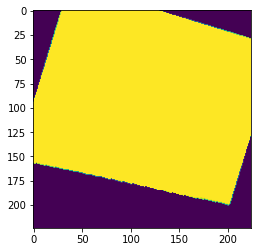

In [ ]:
plt.imshow(np.asarray(inputs[0])[0])

Visualize a few images
----------------------------------
Let's visualize a few training images so as to understand the data
augmentations.



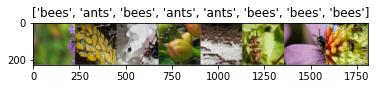

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
----------------------------------

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.vgg16(pretrained=True) #.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train and evaluate
----------------------------------

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 1/30
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5165 Acc: 0.7459
val Loss: 0.1991 Acc: 0.9412

Epoch 2/30
----------
train Loss: 0.3007 Acc: 0.8648
val Loss: 0.1817 Acc: 0.9412

Epoch 3/30
----------
train Loss: 0.2250 Acc: 0.9016
val Loss: 0.2359 Acc: 0.9216

Epoch 4/30
----------
train Loss: 0.2075 Acc: 0.9221
val Loss: 0.1576 Acc: 0.9477

Epoch 5/30
----------
train Loss: 0.1408 Acc: 0.9549
val Loss: 0.1679 Acc: 0.9412

Epoch 6/30
----------
train Loss: 0.1241 Acc: 0.9467
val Loss: 0.1769 Acc: 0.9412

Epoch 7/30
----------
train Loss: 0.1944 Acc: 0.9180
val Loss: 0.1639 Acc: 0.9412

Epoch 8/30
----------
train Loss: 0.2082 Acc: 0.9139
val Loss: 0.1776 Acc: 0.9477

Epoch 9/30
----------
train Loss: 0.1359 Acc: 0.9426
val Loss: 0.1708 Acc: 0.9477

Epoch 10/30
----------
train Loss: 0.1672 Acc: 0.9262
val Loss: 0.1734 Acc: 0.9477

Epoch 11/30
----------
train Loss: 0.1394 Acc: 0.9426
val Loss: 0.1754 Acc: 0.9346

Epoch 12/30
----------
train Loss: 0.1433 Acc: 0.9344
val Loss: 0.1724 Acc: 0.9346

Epoch 13/30
----------


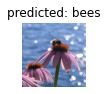

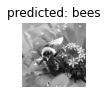

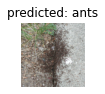

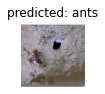

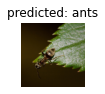

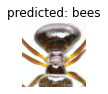

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
----------------------------------

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=30)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()